In [1]:
import sys

import numpy as np
from time import time
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from seismicpro.src.utils import to_list
from seismicpro.src.survey import Survey
from seismicpro.src.gather import Gather
from seismicpro.src.index import SeismicIndex

from seismicpro.src.dataset import SeismicDataset as sd
from seismicpro.src.batch import SeismicBatch
from seismicpro.batchflow import Pipeline, V, F, Notifier, B
from target_benchmark import benchmark_method

In [2]:
path = '/data/H4_SAL2/NA/H4_OUT_mut.sgy'
headers = 'TRACE_SEQUENCE_FILE'

sur_traces = Survey(path, header_index=headers, header_cols=None, name='raw')
traces_dataset = sd(surveys=sur_traces)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

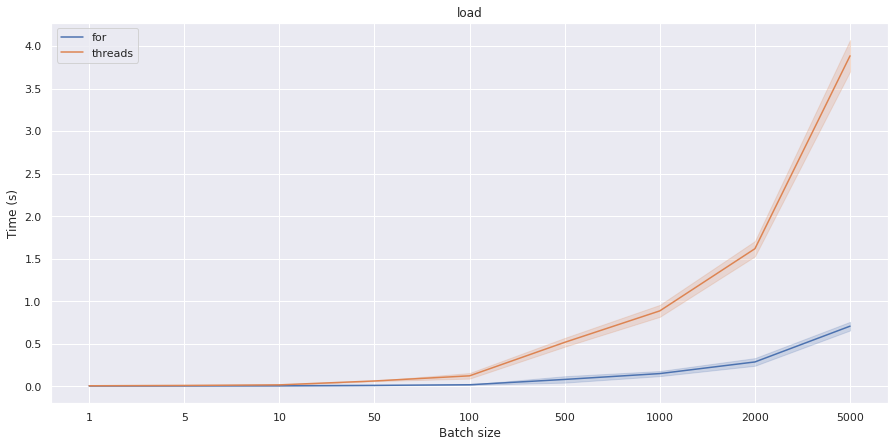

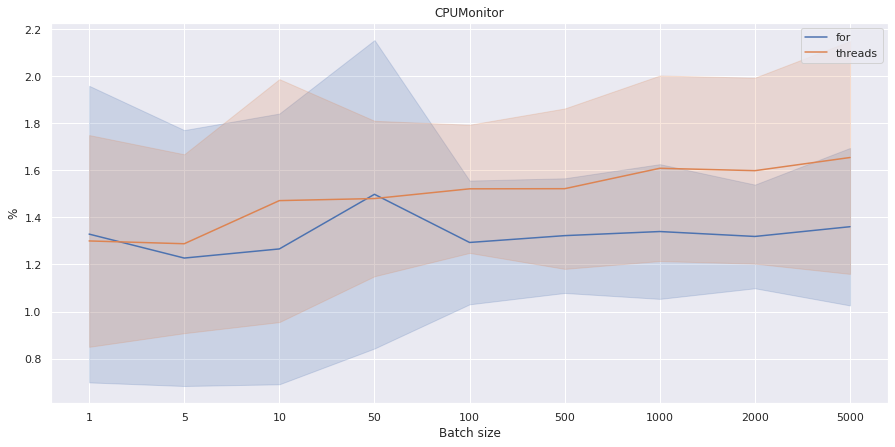

In [3]:
method_kwargs = dict(fmt='segy')
benchmark_method(SeismicBatch.load, traces_dataset, targets=('for', 'threads'), batch_sizes=[1, 5, 10, 50, 100, 500, 1000, 2000, 5000],
                        n_iters=50, root_ppl=None, src='raw', notifier_monitors='cpu', **method_kwargs)

In [3]:
headers = 'FieldRecord'

sur_gathers = Survey(path, header_index=headers, header_cols=None, name='raw')
gathers_dataset = sd(surveys=sur_gathers)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

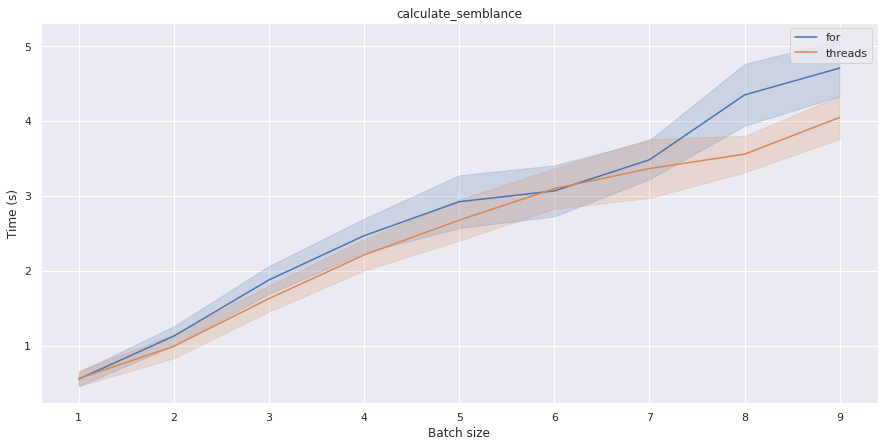

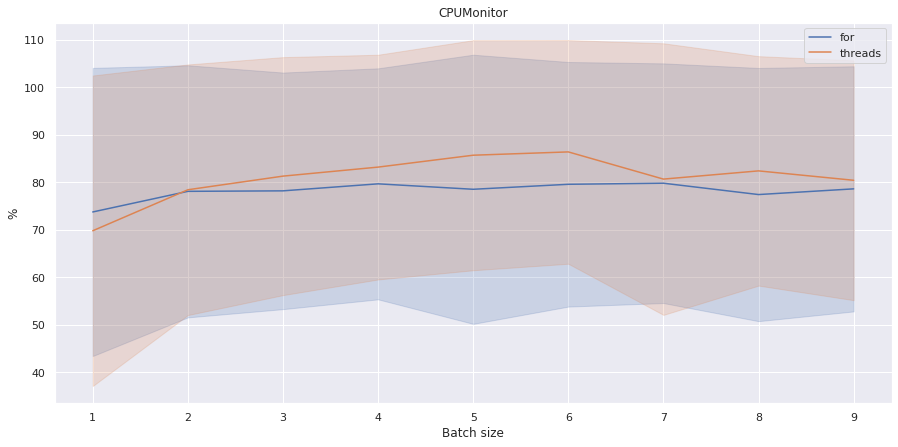

In [5]:
method_kwargs = dict(velocities=np.linspace(1300, 5500, 140), win_size=25)
times, notifiers = benchmark_method(Gather.calculate_semblance, gathers_dataset, targets=('for', 'threads'), batch_sizes=np.arange(1, 10),
                 n_iters=10, root_ppl='sort', src='raw', notifier_monitors='cpu', **method_kwargs)